# Tensorflow Tutorial Exercise 01
## Simple Linear Model
by Bhargav Kanakiya (kanakiyab@gmail.com) | [GitHub](https://github.com/bkanaki)

(original tutorial by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)
/ [GitHub](https://github.com/Hvass-Labs/TensorFlow-Tutorials) / [Videos on YouTube](https://www.youtube.com/playlist?list=PL9Hr9sNUjfsmEu1ZniY0XpHSzl5uihcXZ))

In this exercise, we will see the simple llinear model for MNIST digit classification using tensorflow. Following questions are addressed in this notebook. They are questions from the tuutorial 01 by Hvass labs (link at the top):

* Change the learning-rate for the optimizer.
* Change the optimizer to e.g. `AdagradOptimizer` or `AdamOptimizer`.
* Change the batch-size to e.g. 1 or 1000.
* How do these changes affect the performance?
* Do you think these changes will have the same effect (if any) on other classification problems and mathematical models?
* Do you get the exact same results if you run the Notebook multiple times without changing any parameters? Why or why not?
* Change the function `plot_example_errors()` so it also prints the `logits` and `y_pred` values for the mis-classified examples.
* Use `sparse_softmax_cross_entropy_with_logits` instead of `softmax_cross_entropy_with_logits`. This may require several changes to multiple places in the source-code. Discuss the advantages and disadvantages of using the two methods.
* Remake the program yourself without looking too much at this source-code.
* Explain to a friend how the program works.

Lets' start with remaking the whole program in a way that it explains to a friend (which could be anyone reading this)

In [1]:
# import all libraries to be used
%matplotlib inline
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

### Import the MNIST data, define the image properties (size, dimensions, etc)

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


This input checked if the data exists in the specified directory, if not then it is downloaded. The labels of the classes are one hot encoded. We will see its meaning soon.

The data consists of 70k digit images, divided into train/validation/test sets of size 55k/5k/10k.

In [3]:
print("Size of:")
print("- Training size:\t{:,}".format(len(data.train.labels)))
print("- Validation size:\t{:,}".format(len(data.validation.labels)))
print("- Test size:\t\t{:,}".format(len(data.test.labels)))

Size of:
- Training size:	55,000
- Validation size:	5,000
- Test size:		10,000


Let's setup the data dimensions now.

In [4]:
img_size = 28

img_dim = (img_size, img_size)

img_size_flat = img_size*img_size

num_classes = 10

Let's look at the data, including the images and the labels, both one-hot encoded and actual class.

In [5]:
# one-hot encoded labels, meaning, each row of the dataset contains 0, 
# except for the class that the label represents. This position is set to 1.
data.test.labels[0:5]

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.]])

In [6]:
# This is seen by printing the corresponding classes.
# But first, we convert these labels to the classes.
data.test.cls = np.argmax(data.test.labels, 1)
# data.test.cls = np.array([label.argmax() for label in data.test.labels])
data.test.cls[0:5]

array([7, 2, 1, 0, 4])

In [7]:
# Let's look at the images now, by defining a helper function
def show_digits(imgs, cls_true, cls_pred = None):
    assert len(imgs) == len(cls_true) == 10
    
    fig, axes = plt.subplots(2,5)
    fig.subplots_adjust(hspace=0.3, wspace=0.4)
    
    for i, ax in enumerate(axes.flat):
        ax.imshow(imgs[i].reshape(img_dim), cmap='binary')

        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            assert len(cls_pred) == len(cls_true)
            xlabel = "True: {0}\nPred: {1}".format(cls_true[i], cls_pred[i])

        ax.set_xlabel(xlabel)
        
        ax.set_xticks([])
        ax.set_yticks([])

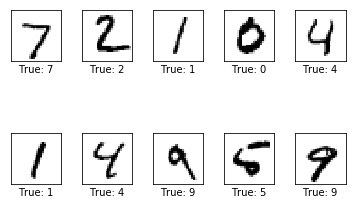

In [8]:
imgs = data.test.images[0:10]
cls_true = data.test.cls[0:10]

show_digits(imgs, cls_true)

### Tensorflow

Now that we have figuresd out and set up the data, time to do some learning from the data using Tehsorflow graphs. Generally, the images are the input to a model and the output is the label representing the class of the image.

The linear model for clasification is given as:

$$ y_{pred} = f(W^Tx + b) $$

In Tensorflow, the inputs ($x$) and outputs ($y$) are the placeholders. Let's start with their definitions.

In [9]:
x_img = tf.placeholder(tf.float32, shape=(None, img_size_flat))
y_true = tf.placeholder(tf.float32, shape=(None, num_classes))
y_true_cls = tf.placeholder(tf.int64, shape=(None))

The model parameters, namely weights ($W$) and biasis ($b$) are defined as Tensorflow variables. These are optimized to find the best representation of the data $x$.

In [10]:
weights = tf.Variable(tf.zeros(shape=(img_size_flat, num_classes)))
biases = tf.Variable(tf.zeros(shape=(num_classes)))

Now, we define the model as per the equation above. Important thing to note is that there will be no computations yet. Only the Tensorflow graph structure is created. Moreover, the size of the ```logits``` matrix is ```[num_images, num_classes]``` as size of ``` weights``` is ```[img_size_flat, num_classes]``` and size of ```x_img``` is ```[num_images, img_size_flat]```

In [11]:
logits = tf.matmul(x_img, weights) + biases
y_pred = tf.nn.softmax(logits)
y_pred_cls = tf.argmax(y_pred, axis=1) # important to note that it should be tf.argmax, not np.argmax

Once the model is defined, we need to define optimization of the loss (cost function) by using one of the optimization algorithms provided in tensorflow library.

In [12]:
# define the cost function
# cross_entropy_loss = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y_true)
# change labels to y_true_cls for using sparse_softmax_cross_entropy_with_logits
cross_entropy_loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y_true_cls)
loss = tf.reduce_mean(cross_entropy_loss)
# define the optimizer
optimizer = tf.train.AdagradOptimizer(learning_rate=0.5).minimize(loss)

In [13]:
# performance measures
correct_pred = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

### Tensorflow session

Now that all the placeholders, variables, optimization methods and performance measures are set, we can run the graph in tensorflow by creating a session.

In [14]:
session = tf.Session()

Once we start the session, we initialize the variables before starting optimization

In [15]:
session.run(tf.global_variables_initializer())

### Stochastic gradient descent optimization

We will optimize in batches, as optimizing a training set of 50k images at one go is time consuming. We define the function for performing stochastic gradient descent optimization.

In [16]:
batch_size = 100
def SGD_optim(epochs):
    for i in range(epochs):
        x_img_batch, y_true_batch = data.train.next_batch(batch_size)
        # next line is added to use the sparse_softmax_cross_entropy_with_logits for loss function
        y_true_batch_cls = np.argmax(y_true_batch, axis=1)
        dict_feed_train = {x_img: x_img_batch,
#                            y_true: y_true_batch} uncomment this and comment next line for non sparse loss
                          y_true_cls: y_true_batch_cls}
        session.run(optimizer, feed_dict=dict_feed_train)

### Some helper functions for measuring the performance

In [17]:
dict_feed_test = {x_img: data.test.images,
                     y_true: data.test.labels,
                     y_true_cls: data.test.cls}

In [18]:
def print_accuracy():
    acc = session.run(accuracy, feed_dict=dict_feed_test)
    print("Accuracy on test set: {:.2%}".format(acc))

In [19]:
def show_confusion_matrix():
    true_cls = data.test.cls
    pred_cls = session.run(y_pred_cls, feed_dict=dict_feed_test)
    
    conf_mat = confusion_matrix(y_true=true_cls, y_pred=pred_cls)
    print(conf_mat)
    
    plt.imshow(conf_mat, interpolation='nearest', cmap=plt.cm.Blues)

    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

In [20]:
def plot_example_errors():
    correct, pred_cls, logits_i, y_pred_i = session.run([correct_pred, y_pred_cls, logits, y_pred],
                                    feed_dict=dict_feed_test)
    
    incorrect = (correct == False)
    
    error_img = data.test.images[incorrect]
    pred_cls = pred_cls[incorrect]
    true_cls = data.test.cls[incorrect]
    
    show_digits(imgs=error_img[0:10],
                cls_true=true_cls[0:10],
                cls_pred=pred_cls[0:10])
    # printing logits and y_pred values for the mis-classified examples
    print("Logits and y_pred values for mis-classified examples:")
    for i in range(10):
        print("True class: {0}\n -- logits: {1}\n -- y_pred{2}".format(true_cls[i], logits_i[i], y_pred_i[i]))

In [21]:
# function to visualize the weights 
def show_weights():
    w = session.run(weights)
    
    w_min = np.min(w)
    w_max = np.max(w)
    
    fig, axes = plt.subplots(2,5)
    
    for i, ax in enumerate(axes.flat):
        img = w[:,i].reshape(img_dim)
        
        ax.imshow(img, vmin=w_min, vmax=w_max, cmap='seismic')
        ax.set_xlabel("Weights {}".format(i))
        
        ax.set_xticks([])
        ax.set_yticks([])
        

### Performance before any optimization

In [22]:
print_accuracy()

Accuracy on test set: 9.80%


Logits and y_pred values for mis-classified examples:
True class: 7
 -- logits: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 -- y_pred[ 0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1]
True class: 2
 -- logits: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 -- y_pred[ 0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1]
True class: 1
 -- logits: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 -- y_pred[ 0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1]
True class: 4
 -- logits: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 -- y_pred[ 0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1]
True class: 1
 -- logits: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 -- y_pred[ 0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1]
True class: 4
 -- logits: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 -- y_pred[ 0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1]
True class: 9
 -- logits: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 -- y_pred[ 0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1]
True class: 5
 -- logits: [ 0.  0.  

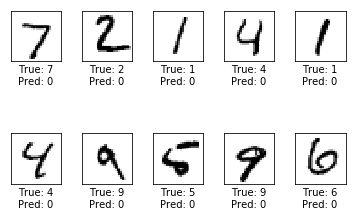

In [23]:
plot_example_errors()

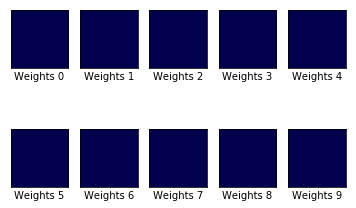

In [24]:
show_weights()

Running one iteration of the optimization and measuring the accuracy.

In [25]:
SGD_optim(epochs=1)
print_accuracy()

Accuracy on test set: 40.93%


Logits and y_pred values for mis-classified examples:
True class: 2
 -- logits: [ 0.78657329 -2.00659871 -1.86792803  0.53371501  1.0180521  -1.30547023
  0.59463453  1.57979918  0.72711289 -0.06558412]
 -- y_pred[ 0.12992622  0.00795495  0.00913822  0.10089783  0.16376714  0.0160374
  0.10723557  0.28720397  0.12242595  0.05541272]
True class: 4
 -- logits: [ 1.0939368  -1.11868334 -0.85108721  1.44427049 -1.16692638 -1.06487012
  3.6333921  -1.76258588  1.87488079 -2.1420095 ]
 -- y_pred[ 0.05603888  0.00613142  0.00801265  0.07954949  0.00584264  0.00647041
  0.71016765  0.00322046  0.12236272  0.00220362]
True class: 9
 -- logits: [-0.38855657  1.54238176 -0.628672    0.59756607 -0.79929644 -0.62397611
  0.95237416 -0.24212463  0.47702545 -0.91537607]
 -- y_pred[ 0.04816052  0.33211386  0.03788003  0.12910967  0.0319381   0.03805833
  0.18409838  0.05575525  0.11444812  0.02843782]
True class: 5
 -- logits: [ 6.52829123 -4.3512311  -3.34133172  0.33888662 -0.3148306  -2.46954465
  

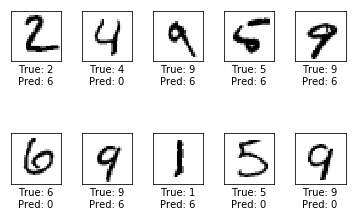

In [26]:
plot_example_errors()

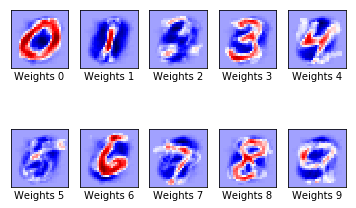

In [27]:
show_weights()

By looking at the weights, we can say that the weights corresponding to classes 2, 5, and 9 are ugly! Meaning, there is a lot of negative values (represented by darker shade of blue) and thus, the prediction will possibly have an impact on these classes. Let's look at the confusion matrix to corroborate our argument.

[[888   0   0   0   0   0  89   0   3   0]
 [  0 538   0   2   0   0 398   0 197   0]
 [148   0   0  86   0   0 718   0  80   0]
 [136   0   0 642   0   0 168   0  64   0]
 [136   0   0  19 303   0 502   0  22   0]
 [426   1   0  48   2   0 305   0 110   0]
 [ 82   0   0   0   0   0 876   0   0   0]
 [329   3   0  44  12   0 288 228 124   0]
 [ 77   0   0  27   2   0 250   0 618   0]
 [169   0   0  34 116   0 554   0 136   0]]


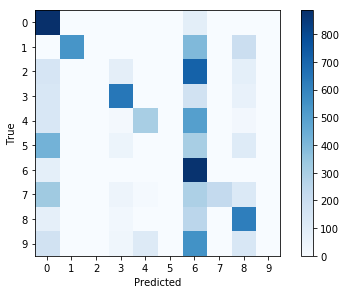

In [28]:
show_confusion_matrix()

Amazing! None of the few classes are predicted at all. This is because at the time of prediction, inner product between weights and the flattened version of the image is taken, and as most of the values in these classes are negative, the classifier ends up classifying them as some other labels with a relatively higher inner product.

Now let's optimize for more number of iterations. As one would guess, the weights of classes should start becoming more positive, and maybe less uglier. We will train for 100 iterations now. As we have already performed 1 iteration, the code takes in 99 for nest run.

In [29]:
SGD_optim(epochs=99)

In [30]:
print_accuracy()

Accuracy on test set: 89.04%


The accuracy increased significantly! Let's look at the example errors, weights and confusion matrix.

Logits and y_pred values for mis-classified examples:
True class: 5
 -- logits: [ -0.35223573  -6.37465      0.99423909   2.77413392  -0.65206188
  -2.94482517  -5.06750774  11.12849045   0.45235673   3.11301303]
 -- y_pred[  1.03205502e-05   2.50150869e-08   3.96706528e-05   2.35216547e-04
   7.64698416e-06   7.72245869e-07   9.24455250e-08   9.99352992e-01
   2.30745263e-05   3.30096867e-04]
True class: 4
 -- logits: [  4.59465742  -0.24336913   9.79928589   4.6358943   -9.26498032
   3.60580373   5.44816065 -10.7249279    1.6877439   -7.69762707]
 -- y_pred[  5.34937531e-03   4.23813544e-05   9.74191844e-01   5.57457842e-03
   5.11845499e-09   1.98998232e-03   1.25595713e-02   1.18875321e-09
   2.92312005e-04   2.45375578e-08]
True class: 5
 -- logits: [-4.56095362  5.92151928  2.47925019  0.11989722 -1.01846147 -2.10020852
  0.49318689  0.32609755  1.45494771 -1.66674614]
 -- y_pred[  2.65262497e-05   9.46577549e-01   3.02829184e-02   2.86117080e-03
   9.16560122e-04   3.10716394e-

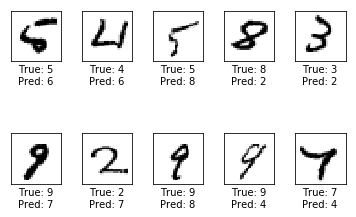

In [31]:
plot_example_errors()

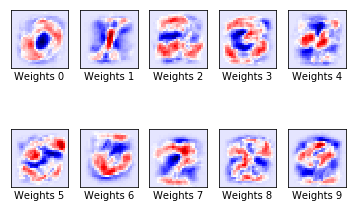

In [32]:
show_weights()

[[ 938    0    2    3    1    9   19    3    5    0]
 [   0 1110    6    1    0    0    4    3   11    0]
 [   8    3  942    9    8    1   21   20   18    2]
 [   2    3   49  892    2   18    4   17   18    5]
 [   0    4   13    0  888    0   30    1   14   32]
 [  11    6   16   61   21  649   25   18   75   10]
 [   5    3   11    2    7    3  922    1    4    0]
 [   2   12   37    2   11    0    1  946    1   16]
 [   8   17   46   21   17   17   17   19  797   15]
 [  10    9    8   11   77    4    2   56   12  820]]


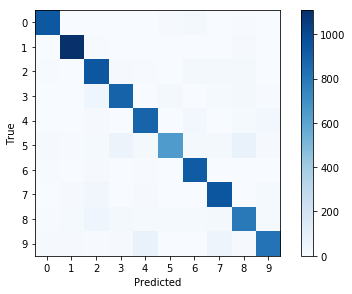

In [33]:
show_confusion_matrix()

We can see that there's a huge improvement in accuracy. Moreover, all the weights are now less ugly (ugliness is the measure of number of negative values, here). We can see some blue parts but these correspond to most of the white regions in the actual image, which are in turn 0 and thus, there's no significant contribution when we take the inner product.

Let's now train for 1000 iterations. And then, we will address some of the questions posed as exercise, mentioned at the beginning of the notebook.

Accuracy on test set: 91.25%
[[ 964    0    1    1    0    8    2    2    2    0]
 [   0 1111    2    1    0    1    3    2   15    0]
 [  10   25  890    9    9    6    5   10   60    8]
 [   5    1   18  884    0   33    1   13   43   12]
 [   2    5    8    1  905    0    1    3   12   45]
 [  11    3    5   25   10  765    5    5   54    9]
 [  21    3   16    1   26   26  843    3   19    0]
 [   3   14   20    5    6    1    0  936    4   39]
 [   4    9    6    9    8   15    3    8  908    4]
 [   9    8    1    5   26    6    0   21   14  919]]
Logits and y_pred values for mis-classified examples:
True class: 5
 -- logits: [  0.69607562 -10.23153591   1.62532365   5.54340887  -2.66527295
   0.36674309  -9.98183155  12.96974564   1.0801065    3.00278711]
 -- y_pred[  4.67005839e-06   8.38533687e-11   1.18274056e-05   5.94966405e-04
   1.61997136e-07   3.35965797e-06   1.07638246e-10   9.99331355e-01
   6.85653913e-06   4.68936669e-05]
True class: 4
 -- logits: [  6.98873663   0

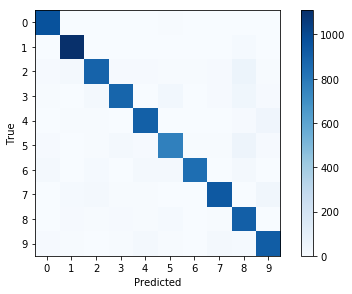

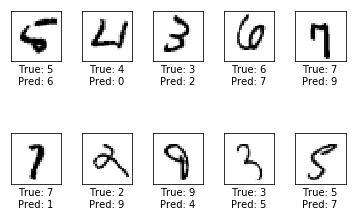

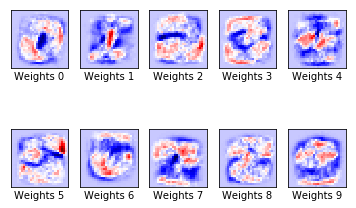

In [34]:
SGD_optim(epochs=900)
print_accuracy()
show_confusion_matrix()
plot_example_errors()
show_weights()

Firstly, we answer the following questions:

* Change the learning-rate for the optimizer.
    * If we increase the learning rate, then there is a chance that the optimization may never reach it's minimum and will keep oscillating around the minima. This, if we perform the same experiment with learning rate of 5 instead of 0.5, then the accuracy drops to 68% after 1000 iterations eventhough, at 100 iterations, the accuracy was 76%. However, if we reduce the learning rate, say to 0.05 instead of 0.5, the training takes more time to achieve the same accuracy which is achieved by using a learning rate of 0.5. With the rate as 0.05, after 1000 iterations, the accuracy is 90% whereas with 0.5, it was 92%.
* Change the optimizer to e.g. `AdagradOptimizer` or `AdamOptimizer`.
    * Changing the optimizer, with the same learning rate, does not seem to change the final accuracy. This means that in this case, all the optimizers are able to find the global minima. However, the results have some variation of 1% due to numerical calculations.
* Change the batch-size to e.g. 1 or 1000.
    * Reducing the batch size to a very low value of 1 reduces the accuracy significantly for the same number of iterations. When using batch size of 100, the accuracy is 92% but when batch size is 1, the accuracy is 82%. Thus, we need more number of iterations and hence larger training time to achieve a higher accuracy. On the contrary, increasing batch size aids in faster learning. As in, within 100 iterations, it achieves accuracy of 90% whereas with the batch size of 100, it is about 87%. However, as the batch size is higher, processing each iteration is time consuming and thus, it takes more time when we run 1000 iteration. Even then, there is no significant gain (gain of less than 1%) in the accuracy. So, a very large batch size is also not desireable.
* How do these changes affect the performance?
    * They are mentioned in each of the questions above.
* Do you think these changes will have the same effect (if any) on other classification problems and mathematical models?
    * These changes will have same effect on the other classification problems.
* Do you get the exact same results if you run the Notebook multiple times without changing any parameters? Why or why not?
    * We do not get the exact same results by running the Notebook multiple time as it is nearly impossible to achieve exact same numerical values of the parameters during each run.

In the last part, we use `sparse_softmax_cross_entropy_with_logits` instead of `softmax_cross_entropy_with_logits`. For this, we do not need to define another model which takes in sparse tensors for the computation. For reference, see [here](https://www.tensorflow.org/versions/r0.11/api_docs/python/io_ops/placeholders#sparse_placeholder) and [there](https://www.tensorflow.org/api_guides/python/sparse_ops).

The only changes that are required are in the labels provided to the cross entropy function. Tha labels must be the class index rather than the one hot encoded version. It is mentioned in comments in appropriate cells.